# Decision Tree Classifier 

### Introduction

Decision trees are perhaps to most...

### Theory

There are two main algorithms for growing decision trees: CART (Classification and Regression Tree) developed by Breiman et al. in 1984 and ID3 (Iterative Dichotomiser 3) created by Ross Quinlan in 1986. CART, as its name suggests can create decisions trees which can be used for both regression and classification. On the other hand, ID3 can only be used for classifcation tasks. We should also note that CART itself is an umbrella term that refers to two seperate algorithms that create decision tree classifiers and regressors respectively. Furthermore, it is useful to mention that ID3 was followed by C4.5 and C5.0, which are more widely used in practice. In this notebook, we will use CART to implement a _DecisionTreeClassifier_. Before we do so, it is worth comparing these algorithms,

| Feature                         | **CART**                                                        | **ID3**                                        |
| ------------------------------- | --------------------------------------------------------------- | ---------------------------------------------- |
| **Full Name**                   | Classification and Regression Trees                             | Iterative Dichotomiser 3                       |
| **Creator**                     | Breiman et al.                                                  | Ross Quinlan                                   |
| **Type of Tasks**               | Classification & Regression                                     | Classification only                            |
| **Output Tree**                 | Binary tree (always 2 children per node)                        | Multi-way tree (one child per attribute value) |
| **Splitting Criterion**         | Gini impurity (classification), Variance (regression)           | Information Gain (Entropy)                     |
| **Pruning**                     | Cost-complexity pruning (post-pruning)                          | Typically no pruning in original ID3           |
| **Handles Continuous Features** | Yes (with threshold-based binary splits)                        | No (requires discretization)                   |
| **Missing Values Handling**     | Built-in support (e.g. surrogate splits)                        | Not handled well in original version           |
| **Tree Structure**              | Always binary                                                   | Can be multi-way based on number of values     |
| **Greedy Algorithm**            | Yes (greedy top-down induction)                                 | Yes (greedy top-down induction)                |
| **Popularity in Practice**      | High (especially as implemented in scikit-learn, XGBoost, etc.) | Mostly of historical interest                  |


Let us first begin by considering the grow algorithm of the tree. We consider a depth-first top-down greedy approach in which we grow the branches of the tree on at a time. CART and ID3 use this  approach primarily for computational efficiency—it is significantly more tractable than trying to globally optimize the entire tree structure.. However, it is also viable to grow the tree using a breadth-wise layer-by-layer approach (we explore this at the very end of the notebook).

### Greedy Algorithm

$$
\begin{array}{ll}
\textbf{Algorithm:} & \text{Gradient Descent}(\boldsymbol{\theta}_{\text{init}}, \eta,  N) \\
1. & \boldsymbol{\theta}_{(0)} \gets \boldsymbol{\theta}_{\text{init}} \\
2. & t \gets 0 \\
3. & \textbf{repeat} \\
4. & \quad t \gets t + 1 \\
5. & \quad \boldsymbol{\theta}_{(t)} \gets \boldsymbol{\theta}_{(t-1)} - \eta \, \nabla_{\theta} J(\boldsymbol{\theta}_{(t-1)}) \\
6. & \textbf{until} \ t=N \\
7. & \textbf{return} \ \boldsymbol{\theta}_{(t)} \\
\end{array}
$$

### Gini-Simpson Index

CART for classification uses the Gini index to determine the optimal splitting of a given node. Let us say that we want to binary split the parent node $P$ into the children nodes $C_L$ and $C_R$ respectively. The optimal split is the split which results in the greatest decrease in Gini index between the parent node $G_P$ and its children $G_{C}$. That is, the split which maximises,

$$\Delta G = G_P - \frac{N_L}{N_P}G_L - \frac{N_R}{N_P}G_R$$ 

In which, $N_L$, $N_R$ and $N_P$ are the number of data points contained within the left child node, right child node and the parent node respectively. Gini index is also refered to as Gini impurity because it quantifies how "pure" a given node is. The smaller the Gini index, the more pure our node is. Purity implies less diversity amongst the class labels of the nodes. Therefore, we want our nodes to get progressively more pure when growing the tree. In particular, our terminal nodes (leaves) should have a purity close to zero such that the majority of class labels belong to only a single class. To compute the Gini index for a given node $m$ denoted as $G_m$ we use the following formula,

$$G_m = \sum^{C}_{k=1}p_{mk}(1-p_{mk})$$

$p_{mk}$ is the probability that a given data point randomly selected from node $m$ will belong to the class $k$ and is computed via $p_{mk}=N_{mk}/N_m$ where $N_{mk}$ is the number of data points in the node $m$ which have the class label $k$ and $N_m$ is the number of data points within the node. By definition, $(1-p_{mk})$ is the probability the randomly selected data point does not have the label $k$ (complement probability). Note that, $C$ is the total number of classes. With this, the maximised purity increase is given by,

$$\Delta G_{max} = \text{argmax}_{\theta} \left[G_P - \frac{N_L}{N_P}G_L - \frac{N_R}{N_P}G_R \right]$$ 

where $\theta = (T_m, j)$ is our decision such that $T_m$ is the feature threshold and $j$ is the chosen feature. In practice values of $T_m$ are sampled for a given feature $j$ and $\Delta_{G}$ is computed for each one. After considering all features, the split with the largest $G_{max}$ and its decision is selected. In the case that $G_{max} > 0$ is not found for any decision, no split will be performed. More details are in the preceeding section. Note that we can rewrite our optimisation problem as,

$$\Delta G_{C} = \text{argmin}_{\theta} \left[ \frac{N_L}{N_P}G_L + \frac{N_R}{N_P}G_R \right]$$ 

Meaning that we want to minmise the weight sum of the impurity of the child nodes created by split.

### Split Algorithm

In [191]:
# Importing,
import numpy as np

class DecisionTreeClassifier():
    """This class implements a DecisionTreeClassifier using the CART algorithm with the functionality of NumPy."""

    def __init__(self, max_depth=None, min_samples_leaf=1, min_samples_split=2):
        """Constructor method for the DecisionTreeClassifier class. We simply create the class variables."""

        # Class variables for the data and nodes,
        self.X, self.y, self.tree_root = None, None, None

        # Stopping criteria,
        if max_depth is None:
            self.max_depth = np.inf
        else:
            self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split

        return None

    def fit(self, X, y):
        """Use this method to fit the tree to the training dataset."""

        # Assignment to class attributes,
        self.X, self.y = X, y

        # Growing the tree,
        self.tree_root = self._grow_tree(X=X, y=y, node_label="O", current_depth=0) # <-- The label "O" is for the root node.

        return None
    
    def predict(self, X):
        """Wrapper method around _traverse_tree() for predictions."""

        # Traversing the tree,
        preds = np.asarray([self._traverse_tree(x, self.tree_root) for x in X]) # <-- Starting at the root node.

        return preds

    def score(self, X, y):
        """Computes the accuracy of the model of the given data."""

        # Storing predictions as an array,
        y_preds = self.predict(X)

        # Computing accuracy,
        accuracy = np.sum(y == y_preds)/len(y)

        return accuracy

    def print_tree(self):
        """Prints the structure of the tree using _traverse_tree_print which traverses the tree."""
        n_nodes = self._traverse_tree_print(node=self.tree_root)
        print(f"Number of nodes: {n_nodes}")
        return None

    def _grow_tree(self, X, y, node_label, current_depth):
        """This function is recursively called and is responsible for the creation of the tree. The function is called every time we create a new node in the tree."""

        # Creating node object,
        current_node = Node(X, y, node_label)

        """STOPPING CRITERIA: maximum depth reached."""
        if current_depth == self.max_depth:

            # Marking as leaf node,
            current_node.is_leaf = True

            # Computing prediction for leaf node,
            current_node.prediction = self._compute_prediction(y_node=current_node.y)

            # Returning leaf node,
            return current_node
        
        """STOPPING CRITERIA: parent node has equal or fewer than min_samples_split number of data points."""
        if len(y) < self.min_samples_split:
            current_node.is_leaf = True
            current_node.prediction = self._compute_prediction(y_node=current_node.y)
            return current_node

        # Splitting node,
        decision, children_data, node_labels, valid_split = self._split(X, y, parent_node=current_node)

        if valid_split: # <-- The case when we have a valid split.

            # Assigning decision to current node,
            current_node.decision = decision
        
            # Unpacking children data,
            X_left, X_right, y_left, y_right = children_data
            left_node_label, right_node_label = node_labels

            # Creating subtrees,
            current_depth += 1
            current_node.child_left = self._grow_tree(X=X_left, y=y_left, node_label=left_node_label, current_depth=current_depth) # <-- We grow the branch from the left node first.
            current_node.child_right = self._grow_tree(X=X_right, y=y_right, node_label=right_node_label, current_depth=current_depth) # <-- We backtrack and then grow the branches from the right nodes.

            # Returning our current node,
            return current_node

        else: #<-- The case when we do NOT have a valid split,

            # Our current node must be a leaf node,
            current_node.is_leaf = True
            current_node.prediction = self._compute_prediction(y_node=current_node.y)
            return current_node

    def _split(self, X, y, parent_node):
        """Binary splits a parent node into two child nodes based on the decision that mimises the SSE (sum of squared errors) of the
        child nodes."""

        # Placeholder variables,
        max_delta_gini = 0 # <-- Initial value
        split_threshold_value = None
        found_split = False
        X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = None, None, None, None

        # Compute Gini index of parent node,
        parent_gini = self._compute_gini(y_node=y)

        # Double loop, first for each feature, second for each threshold value,
        for feature_idx in range(X.shape[1]):

            # Extracting feature values,
            X_feature = X[:, feature_idx]

            # Thresholds taken as the midpoint between sorted values,
            X_feature_sorted = np.sort(X_feature)
            thresholds = np.unique((X_feature_sorted[:-1] + X_feature_sorted[1:]) / 2)

            for threshold_value in thresholds:

                # Splitting data,
                left_split_idxs, right_split_idxs = np.where(X_feature <= threshold_value)[0], np.where(X_feature > threshold_value)[0]
                X_left_split, X_right_split = X[left_split_idxs], X[right_split_idxs]
                y_left_split, y_right_split = y[left_split_idxs], y[right_split_idxs]

                # Reject splits which result in child nodes having less data points that the minimum number,
                if len(left_split_idxs) < self.min_samples_leaf or len(right_split_idxs) < self.min_samples_leaf:
                    continue

                # Compute Gini index of children nodes,
                children_gini = (len(y_left_split)/len(y))*self._compute_gini(y_node=y_left_split) + (len(y_right_split)/len(y))*self._compute_gini(y_node=y_right_split)

                # Computing the difference in Gini index,
                delta_gini = parent_gini - children_gini
            
                # Tracking minimum SSE,
                if delta_gini > max_delta_gini:
                    
                    # Reassigning minimum SSE,
                    max_delta_gini = delta_gini
                    found_split = True

                    # Updating nodes associated with the best split,
                    split_threshold_value, split_feature = threshold_value, feature_idx
                    X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = X_left_split, X_right_split, y_left_split, y_right_split

        # Returning relevant data,
        if found_split: # <-- Case 1: We have found a valid split.

            # Packaging data to return,
            node_labels = ((parent_node.label + "L"), (parent_node.label + "R"))
            decision = (split_feature, split_threshold_value)
            children_data = (X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split)

            # Assigning node decision,
            parent_node.decision = decision

            return decision, children_data, node_labels, found_split
        else: #<-- Case 2: No valid split was found.
            return None, None, None, found_split

    def _traverse_tree(self, X_sample, node):
        """Helper function for traversing the tree recurvisely in order to make predictions."""

        if node.is_leaf: # <-- Reached terminal node.
            return node.prediction

        else: # <-- Node has a decision.
    
            # Extracting decision information,
            feature, feature_threshold = node.decision

            # Making decision,
            if X_sample[feature] <= feature_threshold:
                return self._traverse_tree(X_sample=X_sample, node=node.child_left)
            else:
                return self._traverse_tree(X_sample=X_sample, node=node.child_right)

    def _traverse_tree_print(self, node, current_depth=0):
        """Traverses the tree via recursion."""

        # Counting the current node,
        node_count = 1

        indent = "  " * current_depth
        if node.is_leaf:
            print(f"{indent}Leaf → Predict: {node.prediction}")
        else:
            print(f"{indent}If X[:, {node.decision[0]}] <= {node.decision[1]}")
            node_count += self._traverse_tree_print(node.child_left, current_depth + 1)
            print(f"{indent}Else:")
            node_count += self._traverse_tree_print(node.child_right, current_depth + 1)

        # Returning node count,
        return node_count

    @staticmethod
    def _compute_prediction(y_node):
        return np.argmax(np.bincount(y_node))

    @staticmethod
    def _compute_gini(y_node):
        p_class = np.unique(y_node, return_counts=True)[1]/len(y_node)
        return np.sum(p_class*(1-p_class))

class Node():
    """The class for node objects. Essentially used as a container."""

    def __init__(self, X, y, node_label):
        """Constructor method for the node. Class variables contain node information and encode its location in the tree
        required for predictions."""

        # Node information,
        self.X, self.y = X, y
        self.is_leaf = False
        self.decision = None
        self.prediction = None

        # Encodes location in the tree,
        self.label, self.child_left, self.child_right = node_label, None, None

### Implementation

The boilerplate code for our implementation,

In [194]:
# Importing
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Creating dataset,
iris_dataset = load_breast_cancer()
X = iris_dataset["data"]
y = iris_dataset["target"]

# Creating model and fitting,
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Creating model and fitting,
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
clf.print_tree()
clf.score(X_test, y_test)

If X[:, 20] <= 16.76
  If X[:, 27] <= 0.13595
    If X[:, 10] <= 0.97255
      Leaf → Predict: 1
    Else:
      Leaf → Predict: 0
  Else:
    If X[:, 21] <= 26.285
      Leaf → Predict: 1
    Else:
      Leaf → Predict: 0
Else:
  If X[:, 26] <= 0.21805000000000002
    If X[:, 1] <= 19.86
      Leaf → Predict: 1
    Else:
      Leaf → Predict: 0
  Else:
    If X[:, 1] <= 14.955
      Leaf → Predict: 0
    Else:
      Leaf → Predict: 0
Number of nodes: 15


0.9210526315789473

Comparing this to sci-learn's implementation we see comparable performance in terms of accuray. However, there is much left to be desired in terms of speed! (I'm working on it).

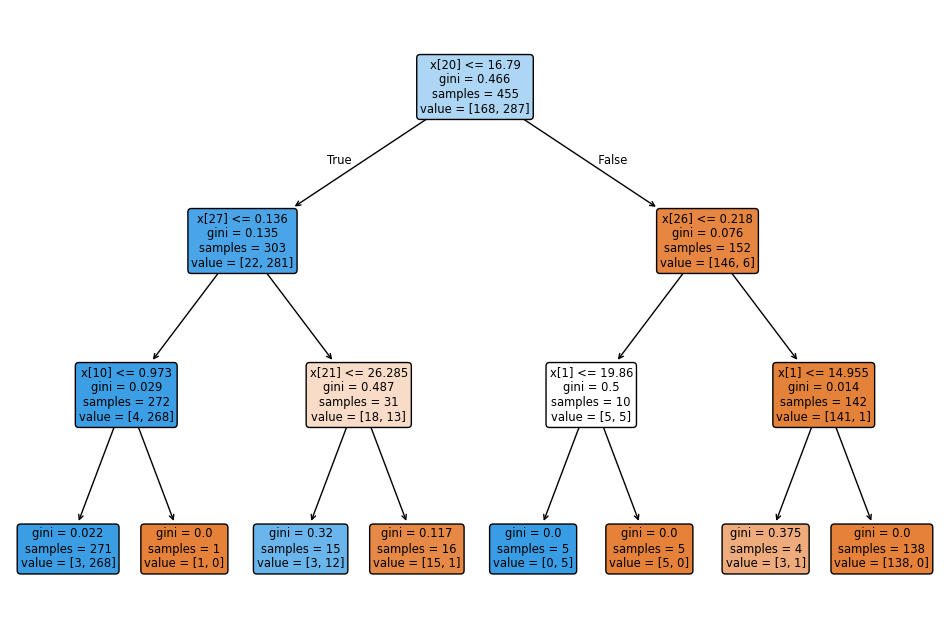

Number of nodes: 15


0.9210526315789473

In [283]:
# Importing,
from sklearn.tree import DecisionTreeClassifier as SKDecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Creating model and fitting,
clf = SKDecisionTreeClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y_train)

# Printing the tree,
plt.figure(figsize=(12, 8))
plot_tree(
    decision_tree=clf,
    filled=True,
    rounded=True
)
plt.show()

# Scoring,
print(f"Number of nodes: {clf.tree_.node_count}")
clf.score(X_test, y_test)


The only discrepancy betwee the tree produced by our implementation and that of sci-kit learn is that many of our threshold values $T_m$ are slightly different. This is because scikit-learn determines threshold values using a gradient-based optimisation method, which searches more finely over potential split points. In contrast, our implementation selects thresholds as the midpoints between sorted data points of the given feature. We should also note that _sklearn.tree.DecisionTreeClassifier_ is not completely deterministic because we are able to specifiy a random state argument. This is in contrast to our implementation which produces completely deterministic trees. Sci-kit learn uses tie-breaking rules which are applied when there is more than one optimal split due to two or more decisions giving exactly the same impurity decrease. An element of randomness is associated with tie-breaking rules.
